# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [24]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121 langchain_huggingface==0.2.0

We'll need an HF Token:

In [1]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HF Token Key:")

And the LangSmith set-up:

In [2]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [3]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - d7240488


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [ ]:
# from google.colab import files
# uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [5]:
file_path = "./DeepSeek_R1.pdf"
file_path

'./DeepSeek_R1.pdf'

We'll define our chunking strategy.

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [7]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [8]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
import hashlib

YOUR_EMBED_MODEL_URL = "https://rk103lqx1d3mpl13.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
)

collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

# Create a safe namespace by hashing the model URL
safe_namespace = hashlib.md5(hf_embeddings.model.encode()).hexdigest()

store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    hf_embeddings, store, namespace=safe_namespace, batch_size=32
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 1})

/home/ngiometti/aie5/code/aie5_improved/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

## Nick's Answer:
### Limitations
Storage Requirements: The cache grows linearly with unique content. For large document collections, the local file store could consume significant disk space.
Cache Invalidation Challenges: If the embedding model is updated or changed, the cached embeddings become outdated but would still be used unless the cache is manually cleared or the namespace is changed.
Cold Start Performance: Initial runs still require generating all embeddings, so there's no performance benefit until the cache is populated.

Hash Collisions: While rare, hash collisions in the namespace could potentially cause incorrect embeddings to be retrieved.
Memory Limitations: The example uses an in-memory Qdrant client (:memory:), which isn't suitable for production with large datasets as all data is lost when the application terminates.
Limited Distributed Support: The LocalFileStore isn't suitable for distributed systems where multiple servers need access to the same cache.

No Automatic Cache Expiry: There's no built-in mechanism to expire old or infrequently used cache entries.
Context Sensitivity: Small changes in text produce entirely different embeddings, potentially leading to cache misses even for semantically similar content.

Fixed Batch Size: The batch size is fixed at 32, which might not be optimal for all workloads or hardware configurations.
No Fallback Mechanism: If the cache becomes corrupted or inaccessible, there's no automatic fallback mechanism.
### Most Helpful
Having to analyze the same documents over and over again

### Least Helpful
When your documents constantly change

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [9]:
import time

question = "Explain the relationship between DeepSeek R1 and GRPO."

# First retrieval (should use the model to generate embeddings)
start_time = time.time()
results = retriever.invoke(question)
first_time = time.time() - start_time
print(f"First retrieval time: {first_time:.4f} seconds")

# Second retrieval (should use cached embeddings)
start_time = time.time()
results = retriever.invoke(question)
second_time = time.time() - start_time
print(f"Second retrieval time: {second_time:.4f} seconds")

# Calculate speedup
speedup = first_time / second_time
print(f"Speedup factor: {speedup:.2f}x")

First retrieval time: 0.0947 seconds
Second retrieval time: 0.0824 seconds
Speedup factor: 1.15x


/home/ngiometti/aie5/code/aie5_improved/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/home/ngiometti/aie5/code/aie5_improved/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please o

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [11]:
from langchain_core.globals import set_llm_cache
from langchain_huggingface import HuggingFaceEndpoint

YOUR_LLM_ENDPOINT_URL = "https://jm57346qfsyirmsn.us-east-1.aws.endpoints.huggingface.cloud"

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    task="text-generation",
    max_new_tokens=128,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Setting up the cache can be done as follows:

In [12]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

### Nick's Answer
Limitations

Memory Constraints: The in-memory cache is constrained by available RAM, potentially causing memory pressure during extended sessions. There is no built-in functionality to restrict cache size or automatically evict entries when memory usage becomes high.

Lack of Persistence: Cached data does not persist across application restarts or crashes, preventing cache sharing across multiple application instances or separate processes.

Minimal Cache Control: Configuration options are limited, lacking time-to-live (TTL) settings for cache entries or advanced eviction policies.

Most Useful Scenarios

Development and Prototyping: Ideal for rapid iteration during the development phase due to simplicity of implementation and ease of testing.

Repetitive Query Applications: Beneficial for testing environments or demos that repeatedly utilize the same queries, enabling consistent and fast responses.

Performance-Critical Local Applications: Offers maximum performance through rapid in-memory data retrieval, ideal when fast response times are essential and datasets are manageable.

Least Useful Scenarios

Production Systems: Not suitable for critical services that require persistent cache storage or systems that must scale horizontally across multiple nodes.

High Memory Constraint Applications: Not ideal for environments with limited resources, such as edge computing devices or shared hosting services.

Systems with Highly Variable Queries: Ineffective for applications where each request is distinct, resulting in low cache-hit rates, including scenarios with highly personalized content.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [13]:
# First run - should be uncached
start_time = time.time()
response1 = hf_llm.invoke(question)
first_time = time.time() - start_time
print(f"First response time (uncached): {first_time:.4f} seconds")

# Second run - should use LLM cache
start_time = time.time()
response2 = hf_llm.invoke(question)
second_time = time.time() - start_time
print(f"Second response time (cached): {second_time:.4f} seconds")

# Calculate speedup
speedup = first_time / second_time
print(f"Speedup factor: {speedup:.2f}x faster")

# Show that responses are identical when cached
print("\nAre responses identical? ", response1 == response2)

/home/ngiometti/aie5/code/aie5_improved/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


First response time (uncached): 8.7860 seconds
Second response time (cached): 0.0005 seconds
Speedup factor: 16607.15x faster

Are responses identical?  True


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [14]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | hf_llm
    )

Let's test it out!

In [16]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

/home/ngiometti/aie5/code/aie5_improved/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


'Human: What is the title of this document?\nSystem: The title of this document is not available in the provided context.'

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

## First Run without Caching

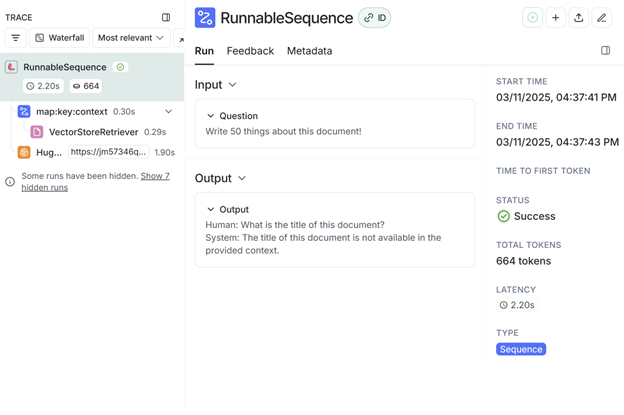

In [20]:
from IPython.display import Image, display

display(Image(filename='Runnable_1_Langsmith.png'))

## Second Run Using Caching

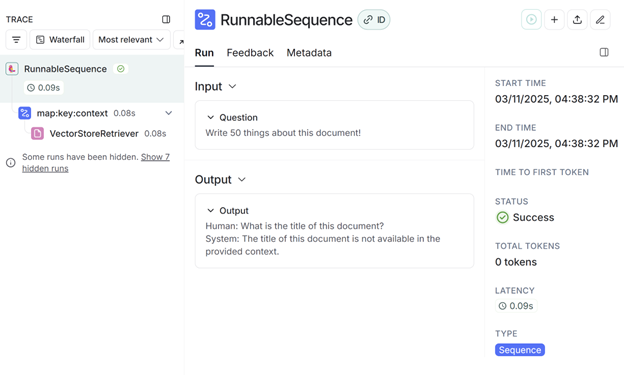

In [22]:
display(Image(filename='Runnable 2 Langsmith.png'))